In [66]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
import time
import pandas as pd
import scipy.stats as scistat
import numpy.random as rand
#from scipy.optimize import curve_fit
#from sklearn.metrics import r2_score
import scipy.signal as signal
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.display import HTML
import matplotlib.font_manager
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm


#from System import System #custom class

In [67]:
import matplotlib.animation as manimation
manimation.writers.list()

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']

In [68]:
def PlotStyle():
    font = {'size':14,  
            'family':'DejaVu Sans', 
           'weight': 'normal'}
    axis = {'labelsize':18, 
           'titlesize':12, 
           'labelpad':18, 
           'labelweight': 'normal', 
           'linewidth': 0.5}
    xtick = {'labelsize': 12}
    ytick = {'labelsize':12}
    legend = {'fontsize':'large',
              'framealpha':0.0}
    figure_sp = {'hspace':0.3}
    axes = {'formatter.use_mathtext':False}
    mathtext = {'fontset':'dejavusans'}
    text = {'usetex': False,
           'latex.unicode':False}
    plt.rc('axes', **axes)
    plt.rc('mathtext', **mathtext)
    plt.rc('axes', **axis);plt.rc('font', **font);plt.rc('xtick', **xtick); plt.rc('ytick', **ytick)
    plt.rc('figure.subplot', **figure_sp);plt.rc('legend', **legend)
    #plt.rc('text', **text)
    

In [334]:
import matplotlib.patches as mpatches
import matplotlib as mpl
class BoxHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle([x0, y0], width, height, facecolor=(0,0,0,0),
                                   transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        return patch

In [69]:
def starttimer():
    global starttime
    starttime = time.time()
def endtimer():
    endtime = time.time()
    runtime = endtime-starttime
    if(runtime > 60):
        runmins = int(runtime/60)
        runsecs = runtime - runmins * 60
        print("Runtime : %d min %.5f secs "%(runmins, runsecs))
    else:
        print("Runtime : %.5f secs"%runtime)
def ProgressBar(index, array, sep = "\n"):
    total = len(array)
    progress = (index/total)*100
    steps = [10*(i+1) for i in range(10)]
    if(progress in steps):
        print(r"%.1f%% done   "%(progress), end = sep)
def SetAxis(ax, x,y,title = '', args = {'fontsize': 18}):
    ax.set_xlabel(x, **args)
    ax.set_ylabel(y, **args)
    ax.set_title(title, **args)
    

In [70]:
# a new class for photodetectors
class PhotoDetector:
    InitOpts = {'RtrnOps':
                    {'indices':'all', 'opts':['spsm', 'nphot']}}
    defaults = \
        {'N':6, #number of spin sites (length of chain)
         'M':10, #number of cavity occupation states
         'J':.1*2*np.pi, #spin-spin coupling 
         'g':.5, #spin-cavity coupling
         'pump1':.1, #first site pumping rate 
         'gammaN':.1, #terminal site spin dissipation
         'kappa':.3} #cavity dissipation 
     
    def __init__(self, pdict = defaults, makeH = True, GetInfo = False, kind = "II", initopts = None):
        if(initopts == None): initopts = PhotoDetector.InitOpts
    # define parameters with defaults
        defp = PhotoDetector.defaults.copy()
    # update with given dict, pdict
        self.defdict = defp.copy()      # first, set to defaults (avoiding changing defaults)
        for p in pdict: 
            if(p in defp): 
                self.defdict.update({p:pdict.get(p)})
        self.N, self.M, self.J, self.g,\
        self.pump1, self.gammaN, self.kappa = (self.defdict.get(i) for i in self.defdict)
    
    # update again for specificed system type
        self.SysUpdate(kind = kind)
        
    # prepare operator lists
        si = qeye(2)
        sx = sigmax()
        sy = sigmay()
        sz = sigmaz()
        sm = destroy(2)
        sp = create(2)
        bi = qeye(self.M)
        
        self.si_list, self.sx_list, self.sy_list, self.sz_list, self.sp_list, self.sm_list = ([] for _ in range(6))
        
        for n in range(self.N):
            op_list = []
            for m in range(self.N):
                op_list.append(si)
          
            if(self.M>0): op_list.append(bi)   

            op_list[n] = sx
            self.sx_list.append(tensor(op_list))

            op_list[n] = sy
            self.sy_list.append(tensor(op_list))

            op_list[n] = sz
            self.sz_list.append(tensor(op_list))

            op_list[n] = sp
            self.sp_list.append(tensor(op_list))

            op_list[n] = sm
            self.sm_list.append(tensor(op_list))
            
            op_list[n] = si
        
    # cavity mode operator
        if(self.M>0):
            aop = destroy(self.M)
            op_list[self.N] = aop
            self.a = tensor(op_list)
            
    # other default parameters
        self.n_th = 0.0 #for thermal bath
        self.w0 = 1.0*2*np.pi #atom frequency
        self.omegac = self.w0 #cavity frequency
        self.H = 0
        self.tdepargs = 0
        
    # set default J_lists
        self.setJconst(self.J, self.J, 0)
        
    # set default c_ops
        self.c_ops = []
        self.gamma = self.VariantCOp(-1, self.gammaN, self.sm_list)
        self.pump = self.VariantCOp(0, self.pump1, self.sp_list)
        if(self.M>0): self.kappa = self.VariantCOp(0, self.kappa, self.a)
        
    # set default r_ops : N sz ops and (if cavity) a^{\dag} a  
        self.r_ops = []
        self.RtrnOps(**initopts['RtrnOps'])
        
    # set initial state
        self.SetPsi0()
        
    # construct Hamiltonian
        if(makeH): self.ConstructH()
    
        if(GetInfo): self.GetInfo()
        
        
     #-----------------------------------  end of __init__   ------------------------------------------------   
    #adjust dictionary for specific system
    def SetParamfromDict(self, usedict):
        self.N, self.M, self.J, self.g, \
        self.pump1, self.gammaN, self.kappa = (usedict.get(i) for i in usedict)
        
    def SysUpdate(self,kind):
        if(kind not in ["I", "II", "III"]): print("SysUpdate: given 'kind' not compatible, (options are 'I', 'II', 'III')")
        ndict = self.defdict.copy()
        if(kind == "I"):
            ndict.update(M=0) 
        if(kind == "II"):
            if not isinstance(ndict['g'], (int, float)): print("warning: g has not been reset to single val"); ndict.update(g = 0.001)
        if(kind == "III"):
            if not isinstance(ndict['g'], (int,float)): print("warning: g has not been reset to single val"); ndict.update(g = 0.001)
            gtemp = [0,]*(self.N-1)+[self.g]
            ndict.update(g = gtemp)
        
        self.defdict = ndict.copy()
        self.SetParamfromDict(ndict)
    
    def setJconst(self, jx, jy, jz):
        self.Jx = jx *np.ones(self.N)
        self.Jy = jy  *np.ones(self.N)
        self.Jz = jz  *np.ones(self.N)
        
    #FOR TIME-INDEPENDENT COLLAPSE OPERATORS
    def VariantCOp(self, indices, vals, oplist): 
        # indices : location in array where collapse coefficient is nonzero
        # vals : values correspoding to indices
        arr = np.zeros(self.N)
        
        #given a single operator (ex: cavity operator)
        if not isinstance(oplist, (list, np.ndarray)):
            if isinstance(indices, (int, float)) and isinstance(vals, (int,float)):
                self.c_ops.append(np.sqrt(vals)*oplist)
                return vals
            
        
        #given list of indices
        if(isinstance(indices, (list, np.ndarray))):
            if len(indices)>len(oplist):
                print("VariantCOp: indices list larger than oplist"); return None
            
            if isinstance(vals, (int, float)): 
                # same val for all indices
                for i in range(len(indices)):
                    arr[indices[i]] = vals
                    self.c_ops.append(np.sqrt(vals)*oplist[i])
                    
            elif isinstance(vals, (list, np.ndarray)): 
                #list of values corresponding to indices
                if (len(indices)!=len(vals)) or (len(indices)>self.N):
                    print("VariantCOp: specificed nonzero indices and/or nonzero values have incorrect shape")
                    return None
                else:
                    for i in range(len(indices)):
                        arr[indices[i]] = vals[i]
                        self.c_ops.append(np.sqrt(vals[i])*oplist[i])
            else: 
                print("Don't understand vals type")
                return None
            
        #given a single indice
        elif isinstance(indices, (int, float)): 
            
            if isinstance(vals, (int,float)): 
                # must be given single value
                arr[indices] = vals
                self.c_ops.append(np.sqrt(vals)*oplist[indices])
                
            else: 
                print("VariantCOp: indices is an int or float, vals must also be an int or float")
                return None
        
        return arr #returns the c_op coefficients as an array 

    def TDepPump(self,func, args = 0):
        self.tdepargs = args
        c_ops = []
        c_ops.append(self.c_ops[0]) #gamma
        if(self.M>0): c_ops.append(self.c_ops[2]) #kappa
        c_ops.append([self.sp_list[0], func])
        self.c_ops = c_ops
            
    def RtrnOps(self, indices = 'all', opts = ['sz', 'nphot']):
        # indices: 'all' or [list of values] for spin sites,      opts: 'opt' or [list of 'opt'] 
        # possible opts:     'nphot' - include a^{\dagger} a     'sz'/'spsm'- type of spin expectation    
        
        #make non-list type indices iterable
        if(indices == 'all'):
            indices = range(self.N) 
        if(isinstance(indices, int) or isinstance(indices, float)):
            indices = [indices]

        for n in indices:
            if('sz' in opts): 
                self.r_ops.append(self.sz_list[n])
            if('spsm' in opts): 
                self.r_ops.append(self.sp_list[n]*self.sm_list[n])

        #cavity expectation
        if(self.M>0 and ('nphot' in opts)):
            self.r_ops.append(self.a.dag()*self.a)
    
    def SetPsi0(self,first = 'excited'):
        psi_list = []
        
        if(first == 'excited'):
            psi_list.append(basis(2,1))
        elif(first == 'ground'):
            psi_list.append(basis(2,0))
        for n in range(self.N-1):
            psi_list.append(basis(2,0))
        
        if(self.M>0):
            psi_list.append(basis(self.M))
        
        psi0 = tensor(psi_list)
        self.psi0 = psi0
        
    def ConstructH(self): 
        
        H = 0
            
        for n in range(self.N):
            H += - 0.5 * self.w0 * self.sz_list[n] 
            
        for n in range(self.N-1):
            H += - 0.5 * self.Jx[n] * self.sx_list[n] * self.sx_list[n+1]
            H += - 0.5 * self.Jy[n] * self.sy_list[n] * self.sy_list[n+1]
            H += - 0.5 * self.Jz[n] * self.sz_list[n] * self.sz_list[n+1]
            
        if(self.M>0): 
            H += self.omegac*self.a.dag()*self.a
            
            for n in range(self.N): 
                if isinstance(self.g, (int, float)): # if g is a single value, assumes inform coupling
                    H+= self.g * (self.a.dag() * self.sm_list[n] + self.sp_list[n]*self.a)
                elif isinstance(self.g, (list, np.ndarray)): # if g is list, must be same size as N
                    if len(self.g) != len(self.sm_list): print("ConstructH: g improper length")
                    H+= self.g[n] * (self.a.dag() * self.sm_list[n] + self.sp_list[n]*self.a)
                
        self.H = H
    
    def expectH(self, tlist = np.linspace(0,50,200), rtrnopt = 'expect', \
                solver = 'mcsolve', ntraj = 500, odeopts = {}, verbose = False, reuse = False): #time evolve hamiltonian
        
        #set solver options
        solveopts = {}
        if(verbose):
            solveopts.update(progress_bar = True)
        else: 
            solveopts.update(progress_bar = None)
        if (solver == 'mcsolve'):
            solveopts.update(ntraj = ntraj)
        if(self.tdepargs !=0):     # if a time-dependent function with arguments is defined, include args in solve()
            solveopts.update(args = self.tdepargs)
            if(verbose): print(solveopts['args'])
            
        if(len(odeopts)>0):
            if(solver !='mcsolve'): print("odeopts only set up for mcsolve, must go in and add to class")
            else:
                opts = Options(**odeopts)
                print("solving with options. Dictionary:", odeopts)
                result = mcsolve(self.H, self.psi0, tlist, self.c_ops, self.r_ops,options = opts,**solveopts)
                return result
                
        if(solver == 'mesolve'):
            print("mesolving...")
            result = mesolve(self.H, self.psi0, tlist, self.c_ops, self.r_ops,**solveopts)
            if not verbose: print("done")
        elif(solver == 'mcsolve'):
            print("mcsolving...")
            result = mcsolve(self.H, self.psi0, tlist, self.c_ops, self.r_ops,**solveopts)
            if not verbose: print("done")
        elif(solver == 'steadystate'):
            print("finding steadystate...", end = '\t')
            rho = steadystate(self.H, self.c_ops)
            result = [expect(op,rho) for op in self.r_ops]
            print("done")
            
        return result
    
                
    def GetInfo(self):
        lname = ["N", "M", "Jx", "Jy", "Jz", "gamma", "pump","num spin collapse ops", "num return ops", "H dims", "coupling, g", "kappa"]
        infolist = [self.N, self.M, self.Jx, self.Jy, self.Jz, self.gamma, self.pump,len(self.c_ops), len(self.r_ops), self.H.shape]
        if(self.M>0): 
            infolist+= [self.g,self.kappa]
            
        for ind,i in enumerate(infolist):
            width = max(len(n) for n in lname)
            print(lname[ind], end = ' '*(width - len(lname[ind])+3))
            if(isinstance(i,float)): print('%.3g'%i)
            elif(isinstance(i, int)): print('%d'%i)
            elif(isinstance(i, str)): print('%s'%i)
            elif(isinstance(i, np.ndarray)):
                if(i[0]==i[-1]): #same value repeating
                    if(isinstance(i[0],float)): print("[%.3f, ....]"%i[0])
                    elif(isinstance(i[0], int)): print("[%d, ....]"%i[0])
                else:
                    print(i)
            elif(isinstance(i, list)):
                if(i[0]==i[-1]): #same value repeating
                    if(isinstance(i[0],float)): print("[%.3f, ....]"%i[0])
                    elif(isinstance(i[0], int)): print("[%d, ....]"%i[0])
                else:
                    print(i)
            else:
                print(i)

        
    

In [71]:
def GetStats(data):
        mu = np.mean(data)
        var = np.var(data)
        skew = scistat.skew(data)
        kurt = scistat.kurtosis(data)
        stdev = np.sqrt(var)
        n = len(data)
        return n, mu, var, skew, kurt

def timediffs(arr):
    outcol = [val for row in arr for val in row]
    outdiff = []
    for row in arr:
        ind = 0
        while((ind+1)<len(row)):
            outdiff.append(row[ind+1]-row[ind]); ind+=1
    return outcol, outdiff
    
def WaitTimes(expt, order = 'gpk'):
    times = expt.col_times
    which = expt.col_which
    origdf = pd.DataFrame(np.vstack([times,which]).T)
    origarr = origdf.values
    itimes, iwhich = [int(0),int(1)]
    if(order ==  'gpk'):
        gamtime, pumptime,kaptime = [np.asarray([origarr[n][itimes][origarr[n][iwhich]==i] for n in range(len(origarr))]) for i in range(3)]
    elif(order == 'kgp'):
        kaptime,gamtime,pumptime = [np.asarray([origarr[n][itimes][origarr[n][iwhich]==i] for n in range(len(origarr))]) for i in range(3)]
    elif(order == 'gkp'):
        gamtime,kaptime,pumptime = [np.asarray([origarr[n][itimes][origarr[n][iwhich]==i] for n in range(len(origarr))]) for i in range(3)]    
    colgamma, gtimediffs  = timediffs(gamtime)    
    colpump, ptimediffs  = timediffs(pumptime)
    colkappa, ktimediffs  = timediffs(kaptime)
    return gtimediffs, ptimediffs, ktimediffs, colgamma,colpump, colkappa

class CollapseFuncs:
    
    def __init__(self, expt, order = 'gpk'):
        self.gtimediffs, self.ptimediffs, self.ktimediffs, self.colgamma, self.colpump, self.colkappa = WaitTimes(expt, order)      
    
    def PlotColTimes(self,ax = None, histopts = None):      
        if(isinstance(ax, type(None))): fig, ax = plt.subplots(figsize = (15,6))
        if isinstance(histopts, type(None)): histopts = {'bins':50, 'histtype':'step'}
        _ = ax.hist(self.colpump, label = 'initial site pumping', color= "green",**histopts)
        _ = ax.hist(self.colgamma,label = 'terminal site emission',color = "red",**histopts)
        _ = ax.hist(self.colkappa, label = 'cavity dissipation', color = "blue", **histopts)
        ax.set_xlabel("Time of Collapse")
        ax.set_ylabel("Frequency")
    
    def PlotWaitTimes(self,ax = None, histopts = None):
        if(isinstance(ax, type(None))): fig, ax = plt.subplots(figsize = (15,6))
        if isinstance(histopts, type(None)): histopts = {'bins':50, 'histtype':'step'}
        _ = ax.hist(self.ptimediffs,color= "green",label = 'inital site pumping', **histopts)
        _ = ax.hist(self.gtimediffs, color = "red", label = 'terminal site emission', **histopts)
        _ = ax.hist(self.ktimediffs, color = "blue", label = 'cavity dissipation', **histopts)
        ax.legend()
        ax.set_xlabel("Time between collapses")
        ax.set_ylabel("Frequency")
    
    def Plot(self, ax = None, histopts = None):
        if(isinstance(ax, type(None))): fig, ax = plt.subplots(1,2,figsize = (15,6))
        self.PlotColTimes(ax = ax[0], histopts = histopts)
        self.PlotWaitTimes(ax = ax[1], histopts = histopts)
        
    def GetStats(self):
        return [GetStats(arr) for arr in [self.gtimediffs,self.ptimediffs,self.ktimediffs]]
    

In [12]:
pdict = PhotoDetector.defaults.copy()
pdict.update(J = 0.5)
pdict

{'N': 6,
 'M': 10,
 'J': 0.5,
 'g': 0.5,
 'pump1': 0.1,
 'gammaN': 0.1,
 'kappa': 0.3}

In [13]:
sysI = PhotoDetector(pdict, kind = "I")
sysII = PhotoDetector(pdict, kind = "II")
sysIII = PhotoDetector(pdict, kind = "III")

for ind, sys in enumerate([sysI, sysII, sysIII]):
    print("System" + ["I", "II", "III"][ind]+"\n")
    sys.GetInfo(); print("\n")

SystemI

N                       6
M                       0
Jx                      [0.500, ....]
Jy                      [0.500, ....]
Jz                      [0.000, ....]
gamma                   [0.  0.  0.  0.  0.  0.1]
pump                    [0.1 0.  0.  0.  0.  0. ]
num spin collapse ops   2
num return ops          6
H dims                  (64, 64)


SystemII

N                       6
M                       10
Jx                      [0.500, ....]
Jy                      [0.500, ....]
Jz                      [0.000, ....]
gamma                   [0.  0.  0.  0.  0.  0.1]
pump                    [0.1 0.  0.  0.  0.  0. ]
num spin collapse ops   3
num return ops          7
H dims                  (640, 640)
coupling, g             0.5
kappa                   0.3


SystemIII

N                       6
M                       10
Jx                      [0.500, ....]
Jy                      [0.500, ....]
Jz                      [0.000, ....]
gamma                   [0.  0.  0.  0

In [25]:
t = np.linspace(0,50,200)
r_I, r_II, r_III = [sys.expectH(t, verbose = True, ntraj = 1000) for sys in [sysI, sysII, sysIII]]

mcsolving...
10.0%. Run time:   1.32s. Est. time left: 00:00:00:11
20.0%. Run time:   2.10s. Est. time left: 00:00:00:08
30.0%. Run time:   2.90s. Est. time left: 00:00:00:06
40.0%. Run time:   3.71s. Est. time left: 00:00:00:05
50.0%. Run time:   4.53s. Est. time left: 00:00:00:04
60.0%. Run time:   5.31s. Est. time left: 00:00:00:03
70.0%. Run time:   6.11s. Est. time left: 00:00:00:02
80.0%. Run time:   6.93s. Est. time left: 00:00:00:01
90.0%. Run time:   7.73s. Est. time left: 00:00:00:00
100.0%. Run time:   8.62s. Est. time left: 00:00:00:00
Total run time:   8.74s
mcsolving...
10.0%. Run time:   3.11s. Est. time left: 00:00:00:27
20.0%. Run time:   5.41s. Est. time left: 00:00:00:21
30.0%. Run time:   7.82s. Est. time left: 00:00:00:18
40.0%. Run time:  10.25s. Est. time left: 00:00:00:15
50.0%. Run time:  12.62s. Est. time left: 00:00:00:12
60.0%. Run time:  15.11s. Est. time left: 00:00:00:10
70.0%. Run time:  17.51s. Est. time left: 00:00:00:07
80.0%. Run time:  19.84s. Est. 

In [358]:
cfunc1, cfunc2, cfunc3 = (CollapseFuncs(rslt, order = 'gpk') for rslt in [r_I, r_II, r_III])

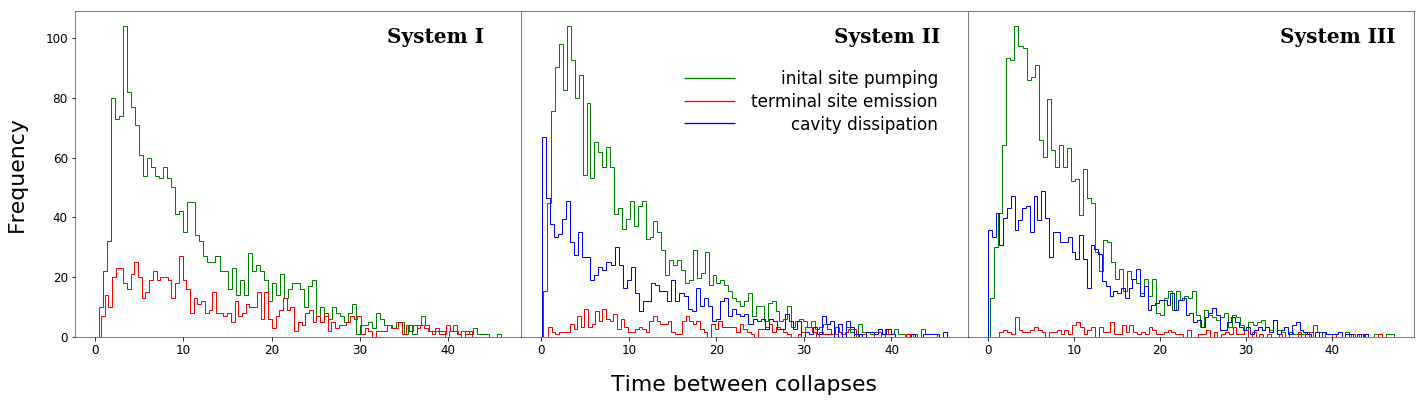

In [359]:
PlotStyle()
histopts = {'bins':100, 'histtype':'step'}
with plt.rc_context({'axes.labelsize':22}):
    fig, ax = plt.subplots(1,3, figsize = (8*3, 6))
    plt.subplots_adjust(wspace = 0)
    _ = [cfunc.PlotWaitTimes(ax[i], histopts) for i, cfunc in enumerate([cfunc1,cfunc2,cfunc3])]
[ax[i].get_legend().remove() for i in [0,2]]
[ax[i].tick_params(left = False, labelleft = False) for i in [1,2]]
[ax[i].set_ylabel("") for i in [1,2]]
[ax[i].set_xlabel("") for i in [0,2]]
legend = ax[1].legend(loc = (.35,0.6), handlelength = 3, handleheight = 0, labelspacing = 0.3)
for ind,label in enumerate(legend.get_texts()):
    label.set_ha("right")
    label.set_position((190,0))
    y_old = legend.get_patches()[ind].get_y()
    legend.get_patches()[ind].set_height(0)
    legend.get_patches()[ind].set_lw(1.3)
    legend.get_patches()[ind].set_y(y_old+2+ind*.5)
    
_ = [plt.text(0.7,0.9,"System %s"%["I", "II", "III"][i], transform = ax[i].transAxes,\
              fontname = 'serif', fontsize = 20, fontweight = 800) for i in range(3)] 


In [72]:
def pcol_coeff(t, args):
    return 10*1.1**(-t)
t = np.linspace(0,100,400)


tdepII = PhotoDetector()
tdepII.GetInfo()
tdepII.TDepPump(pcol_coeff)
resultII = tdepII.expectH(t, verbose = True, odeopts = {'store_states':True, 'average_states':True})

tdepIII = PhotoDetector(kind = 'III')
tdepIII.GetInfo()
tdepIII.TDepPump(pcol_coeff)
resultIII = tdepIII.expectH(t, verbose = True, odeopts = {'store_states':True, 'average_states':True})

N                       6
M                       10
Jx                      [0.628, ....]
Jy                      [0.628, ....]
Jz                      [0.000, ....]
gamma                   [0.  0.  0.  0.  0.  0.1]
pump                    [0.1 0.  0.  0.  0.  0. ]
num spin collapse ops   3
num return ops          7
H dims                  (640, 640)
coupling, g             0.5
kappa                   0.3
solving with options. Dictionary: {'store_states': True, 'average_states': True}
10.0%. Run time:  10.82s. Est. time left: 00:00:01:37
20.0%. Run time:  15.64s. Est. time left: 00:00:01:02
30.0%. Run time:  20.64s. Est. time left: 00:00:00:48
40.0%. Run time:  25.42s. Est. time left: 00:00:00:38
50.0%. Run time:  30.73s. Est. time left: 00:00:00:30
60.0%. Run time:  35.40s. Est. time left: 00:00:00:23
70.0%. Run time:  40.02s. Est. time left: 00:00:00:17


Process ForkPoolWorker-151:
Process ForkPoolWorker-142:
Process ForkPoolWorker-153:
Process ForkPoolWorker-131:
Process ForkPoolWorker-159:
Process ForkPoolWorker-136:
Process ForkPoolWorker-160:
Process ForkPoolWorker-140:
Process ForkPoolWorker-146:
Process ForkPoolWorker-149:
Process ForkPoolWorker-134:
Process ForkPoolWorker-139:
Process ForkPoolWorker-143:
Process ForkPoolWorker-138:
Process ForkPoolWorker-129:
Process ForkPoolWorker-158:
Process ForkPoolWorker-150:
Process ForkPoolWorker-147:
Process ForkPoolWorker-154:
Process ForkPoolWorker-152:
Process ForkPoolWorker-144:
Process ForkPoolWorker-132:
Process ForkPoolWorker-141:
Process ForkPoolWorker-145:
Process ForkPoolWorker-133:
Process ForkPoolWorker-155:
Process ForkPoolWorker-135:
Process ForkPoolWorker-148:
Process ForkPoolWorker-157:
Process ForkPoolWorker-137:
Process ForkPoolWorker-156:
Process ForkPoolWorker-130:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

  File "/home/golin/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golin/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golin/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golin/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golin/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golin/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golin/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golin/anaconda3/lib/python3.7/multiproces

  File "/home/golin/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 840, in _mc_alg_evolve
    ODE.integrate(tlist[k], step=1)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 840, in _mc_alg_evolve
    ODE.integrate(tlist[k], step=1)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 840, in _mc_alg_evolve
    ODE.integrate(tlist[k], step=1)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 840, in _mc_alg_evolve
    ODE.integrate(tlist[k], step=1)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 840, in _mc_alg_evolve
    ODE.integrate(tlist[k], step=1)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 840, in _mc_alg_evolve
    ODE.integrate(tlist[k], step=1)
  File "/home/golin/anaconda3/lib/python3.

  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 79, in step
    r = self.run(*args)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 79, in step
    r = self.run(*args)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 79, in step
    r = self.run(*args)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 79, in step
    r = self.run(*args)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 79, in step
    r = self.run(*args)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 79, in step
    r = self.run(*args)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/qutip/mcsolve.py", line 79, in step
    r = self.run(*args)
  File "/home/golin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py", line 1004, in run
    y1, t, istate = self.runner(*args)
  File "/home/golin/anaconda3/lib

KeyboardInterrupt: 

In [6]:
def restructW(result, Wdiags = True, Wbig = False, input_vec = np.linspace(-5,5,100),verbose = True):
    states = result.states
    if verbose: starttimer()
    lWbig = []; Wall = []; lWdiags = [];  rtrnlist = []
    
    for i, tstate in enumerate(states):
        if verbose: ProgressBar(i, states)
        W, yvec = wigner(tstate.ptrace(6), input_vec,input_vec, method = 'fft')
        Wall.append(W)
        
    for nrow in range(len(input_vec)):
        if(Wbig):temp = np.hstack([W[nrow] for W in Wall]); lWbig.append(temp)
        if(Wdiags): temp2 = [W[nrow][nrow] for W in Wall]; lWdiags.append(temp2)
    vectemp = np.hstack([t,]*(len(input_vec)))
    if(Wdiags): xxd,yyd = np.meshgrid(t, input_vec); [rtrnlist.append(out) for out in [xxd,yyd, lWdiags]]
    if(Wbig): xxb, yyb = np.meshgrid(vectemp, input_vec); [rtrnlist.append(out) for out in [xxb,yyb, lWbig]]
    if verbose:endtimer()
    return rtrnlist

In [273]:
Wreopts = {'input_vec':np.linspace(-6,6,100), 'verbose':False}
xx,yy,z = restructW(resultII, **Wreopts)
xx2, yy2, z2 = restructW(resultIII, **Wreopts)

[Text(0.5, 0, '$\\vec{y}$'), Text(0.5, 0, '$\\vec{y}$')]

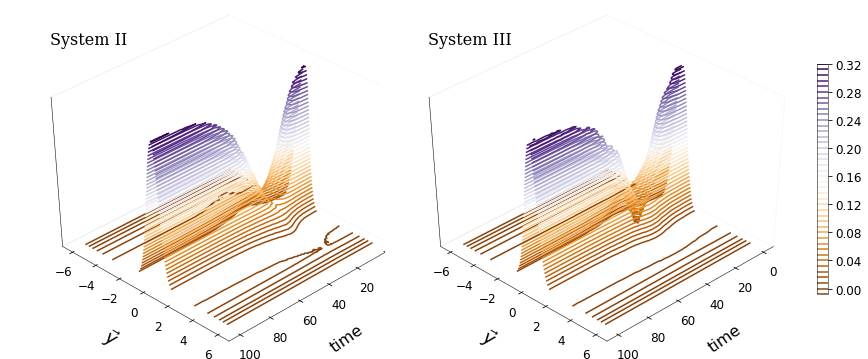

In [515]:
PlotStyle()
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (15,8))
fig.subplots_adjust(wspace = 0.05)
ax = fig.add_axes([0.0, 0.2, 0.4, 0.6],projection = '3d')
ax.view_init(40,45)
ps = ax.contour(xx,yy,np.asarray(z), cmap = 'PuOr', levels = 40)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_zticks([])
cbaxes = fig.add_axes([0.75, 0.3, 0.01, 0.4]) 
fig.colorbar(ps2, shrink = 0.8, cax = cbaxes)

ax2 = fig.add_axes([0.35, 0.2, 0.4, 0.6], projection = '3d')
ax2.view_init(40,45)
ps2 = ax2.contour(xx2,yy2,np.asarray(z2), cmap = 'PuOr', levels = 40)
ax2.grid(False)
# ax2.xaxis.pane.set_edgecolor((0,0,0,1))
# ax2.yaxis.pane.set_edgecolor((0,0,0,0))
# ax2.zaxis.pane.set_edgecolor('white')
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False
ax2.set_zticks([])

fig.text(0.1,0.89,"System II", fontname = 'serif', fontsize = 16, transform = ax.transAxes)
fig.text(0.1,0.89, "System III", fontname = 'serif', fontsize = 16, transform = ax2.transAxes)
[a.set_xlabel("time", fontsize = 16, rotation = 35) for a in [ax,ax2]]
[a.set_ylabel(r"$\vec{y}$") for a in [ax,ax2]]

(None, <matplotlib.axes._subplots.AxesSubplot at 0x7f65984c6588>)

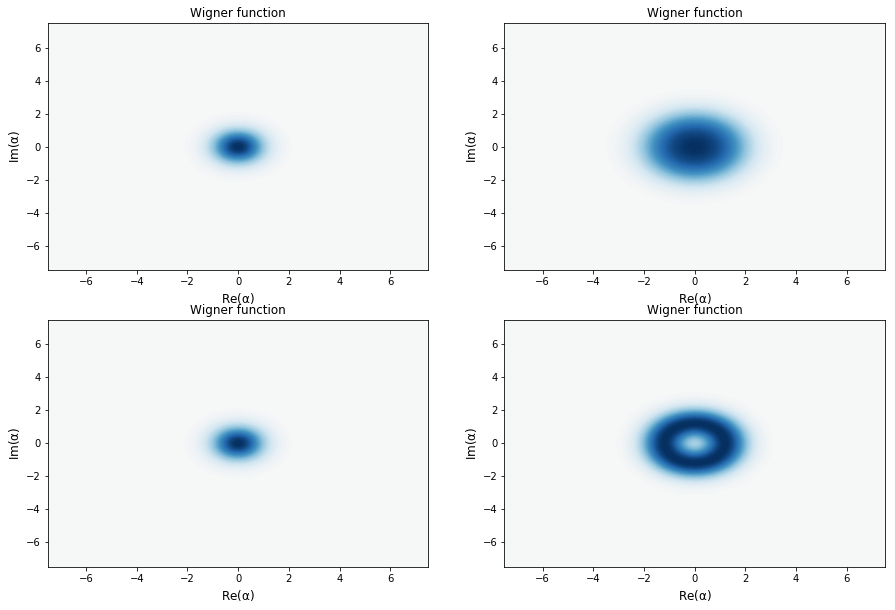

In [31]:
statesIII = resultIII.states
statesII = resultII.states
#statesIII[0]
fig,ax = plt.subplots(2,2,figsize = (15,10))
plot_wigner(statesIII[0].ptrace(6), ax = ax[1][0])
plot_wigner(statesII[0].ptrace(6), ax = ax[0][0])
plot_wigner(statesIII[115].ptrace(6), ax = ax[1][1])
plot_wigner(statesII[115].ptrace(6), ax = ax[0][1])

In [73]:
def pcol_coeff_gauss(t, args):
    a = args['A'] #curve amplitude
    b = args['xmid'] #position of center of peak
    c = args['w'] #curve width (s.d.)
    return a*np.exp(-(t-b)**2/(2*c**2))

In [517]:
t = np.linspace(0,200,800)
args = {'A': 10,
       'xmid': 100,
       'w': 10}
amp_list = [1,2,5,10,15,20]
w_list = [5,10,15]

arglist, listsysII,listsysIII,r_II, r_III = ([] for _ in range(5))
for amp in amp_list:
    argtemp, systemp1,systemp2,temp1, temp2 = ([] for _ in range(5))
    for w in w_list:
        args.update(A = amp, w = w)
        tdepIIB = PhotoDetector()
        #tdepIIB.GetInfo()
        tdepIIB.TDepPump(pcol_coeff_gauss, args)
        starttimer()
        resultIIB = tdepIIB.expectH(tlist = t, verbose = False)
        endtimer()
        systemp1.append(tdepIIB);temp1.append(resultIIB)

        tdepIIIB = PhotoDetector(kind = 'III')
        #tdepIIIB.GetInfo()
        tdepIIIB.TDepPump(pcol_coeff_gauss,args)
        starttimer()
        resultIIIB = tdepIIIB.expectH(tlist = t, verbose = False)
        endtimer()
        systemp2.append(tdepIIIB); temp2.append(resultIIIB)
        
        argtemp.append(args)
        
    listsysII.append(systemp1);listsysIII.append(systemp2);arglist.append(argtemp)
    r_II.append(temp1);r_III.append(temp2)
        

mcsolving...
done
Runtime : 3 min 49.07875 secs 
mcsolving...
done
Runtime : 4 min 1.16149 secs 
mcsolving...
done
Runtime : 2 min 37.44724 secs 
mcsolving...
done
Runtime : 2 min 43.44687 secs 
mcsolving...
done
Runtime : 2 min 24.62395 secs 
mcsolving...
done
Runtime : 2 min 19.59954 secs 
mcsolving...
done
Runtime : 2 min 33.48030 secs 
mcsolving...
done
Runtime : 2 min 21.10099 secs 
mcsolving...
done
Runtime : 2 min 30.89640 secs 
mcsolving...
done
Runtime : 2 min 18.72851 secs 
mcsolving...
done
Runtime : 2 min 25.64722 secs 
mcsolving...
done
Runtime : 2 min 18.20382 secs 
mcsolving...
done
Runtime : 2 min 28.56308 secs 
mcsolving...
done
Runtime : 2 min 27.41937 secs 
mcsolving...
done
Runtime : 2 min 24.05060 secs 
mcsolving...
done
Runtime : 2 min 15.41429 secs 
mcsolving...
done
Runtime : 2 min 22.22578 secs 
mcsolving...
done
Runtime : 2 min 11.36184 secs 
mcsolving...
done
Runtime : 2 min 26.25103 secs 
mcsolving...
done
Runtime : 2 min 22.02222 secs 
mcsolving...
done
Run

In [ ]:
qsave(listsysII, "listsysII")
qsave(listsysIII, "listsysIII")
qsave(arglist, "arglist")
qsave(r_II, "r_II")
qsave(r_III, "r_III")

In [64]:
#file_data_store('listsysII.dat', listsysII)
#file_data_store('listsysIII.dat', listsysIII)
#file_data_store('arglist.dat', arglist)
#file_data_store('r_II.dat', r_II)
#file_data_store('r_III.dat', r_III)

In [74]:
LlistsysII = qload("listsysII")
LlistsysII = qload("listsysIII")
Larglist = qload("arglist")
Lr_II = qload("r_II")
Lr_III = qload("r_III")

Loaded list object.
Loaded list object.
Loaded list object.
Loaded list object.
Loaded list object.


In [79]:
len(Lr_II[0][0].expect)

7

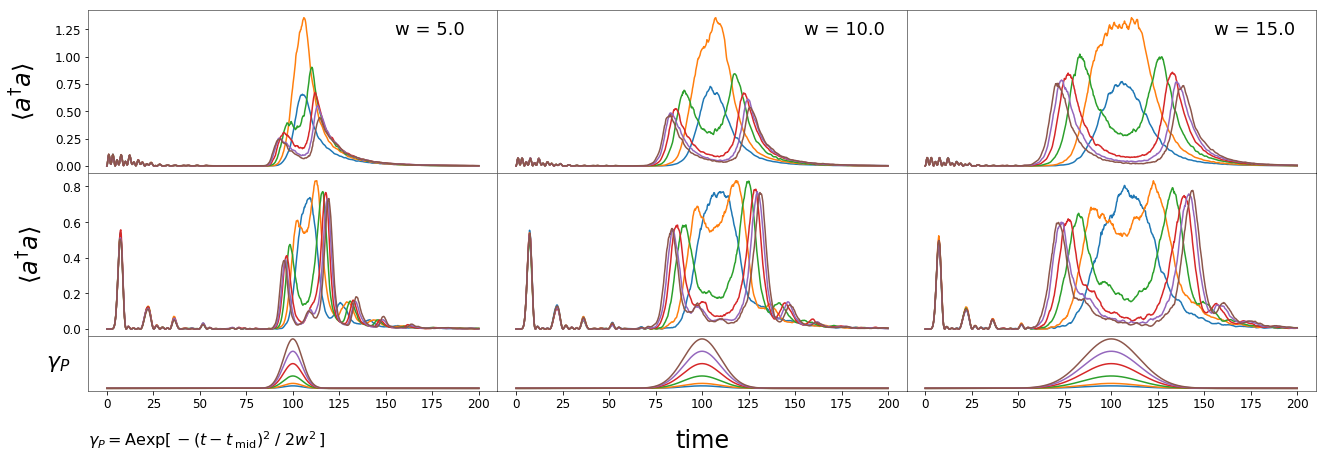

In [346]:
PlotStyle()
fig, ax = plt.subplots(3,3,figsize = (22,7), gridspec_kw={'height_ratios': [3, 3,1]})
plt.subplots_adjust(hspace = 0, wspace = 0)
[ax[2][j].tick_params(left = False, labelleft = False) for j in range(3)] # no pulse y ticks
[ax[i][j].tick_params(left = False, labelleft = False) for i in [0,1] for j in [1,2]] # no expt y ticks
#ylabels
[ax[i][0].set_ylabel(r"$\langle a^{\dagger} a \rangle$", fontsize = 24) for i in range(2)]
ax[2][0].set_ylabel("$\gamma_P$", rotation = 0, fontsize = 22, verticalalignment = 'center',\
                     horizontalalignment = 'right')
#xlabels
ax[2][1].set_xlabel("time", fontsize = 24)
#mcsolve input
t = np.linspace(0,200,800)
args = {'A': 10,
       'xmid': 100,
       'w': 10}
amp_list = [1,2,5,10,15,20]
w_list = [5,10,15]

#results = result[Amplitude][width]
def func_plotAexpts(i_width, axes):
    for i, A in enumerate(amp_list):
        axes[0][i_width].plot(t, Lr_II[i][i_width].expect[-1], label = "A = %.1f"%A) 
        axes[1][i_width].plot(t, Lr_III[i][i_width].expect[-1], label = "A = %.1f"%A) 
        axes[2][i_width].plot(t,pcol_coeff_gauss(t, args = {'A':A, 'w':w_list[i_width], 'xmid':100}))
    plt.text(.75,.85, "w = %.1f"%w_list[i_width], transform = axes[0][i_width].transAxes, fontsize = 18)

func_plotAexpts(0, ax)
func_plotAexpts(1, ax)
func_plotAexpts(2, ax)
#toys

#ax[0][0].legend(loc = (0.05,.55), fontsize = 14)
plt.text(0,-1,'$\gamma_P=\mathrm{A}\exp{[\,-(t-t_{\;\mathrm{mid}})^2\;/\;2w^2\,]}$', fontsize = 16, transform = ax[2][0].transAxes,\
        horizontalalignment = 'left')
plt.show()


In [366]:
fig, ax = plt.subplots(1,2, figsize = (8*2,5)); axi = ax[0]; axii = ax[1]
axi.plot(t, Lr_II[-1][-1].expect[-1])
axi.plot(t, Lr_II[-1][-1].expect[-2])
# axi.plot(t, Lr_II[-1][-1].expect[-3])
# axi.plot(t, Lr_II[-1][-1].expect[-4])
# axi.plot(t, Lr_II[-1][-1].expect[-5])
# axi.plot(t, Lr_II[-1][-1].expect[-6])
axi.plot(t, Lr_II[-1][-1].expect[-7])

axii.plot(t, Lr_III[-1][-1].expect[-1])
axii.plot(t, Lr_III[-1][-1].expect[-2])
# axii.plot(t, Lr_III[-1][-1].expect[-3])
# axii.plot(t, Lr_III[-1][-1].expect[-4])
# axii.plot(t, Lr_III[-1][-1].expect[-5])
# axii.plot(t, Lr_III[-1][-1].expect[-6])
axii.plot(t, Lr_III[-1][-1].expect[-7])


plt.close()

In [7]:
def plotwigner(result,vec,i):
    if  isinstance(i, (int)):
         W, yvec = wigner(result.states[i].ptrace(6),vec, vec, method= 'fft')
    else:
        W_list = []
        for ii in i:
            if not isinstance(ii,int): print("plotwigner 'i' must be index"); return None
            W, yvec = wigner(result.states[ii].ptrace(6),vec, vec, method= 'fft')
            W_list.append(W)
    return W

In [9]:
input_vec = np.linspace(-5,5,100)
statesII = resultII.states
yvecsII = [];WrowsII = [];WsII = []
starttimer()
for i, tstate in enumerate(statesII):
    ProgressBar(i, statesII)
    W, yvec = wigner(tstate.ptrace(6), input_vec,input_vec, method = 'fft')
    yvecsII.append(yvec)
    WrowsII.append(W[int(len(W)/2)])
    WsII.append(W)
    
endtimer() 

10.0% done   
20.0% done   
30.0% done   
40.0% done   
50.0% done   
60.0% done   
70.0% done   
80.0% done   
90.0% done   
Runtime : 6.22808 secs


In [23]:
input_vec = np.linspace(-5,5,100)
statesIII = resultIII.states
yvecsIII = [];WrowsIII = [];WsIII = []
starttimer()
for i, tstate in enumerate(statesIII):
    ProgressBar(i, statesIII)
    W, yvec = wigner(tstate.ptrace(6), input_vec,input_vec, method = 'fft')
    yvecsIII.append(yvec)
    WrowsIII.append(W[int(len(W)/2)])
    WsIII.append(W)
    
endtimer() 

10.0% done   
20.0% done   
30.0% done   
40.0% done   
50.0% done   
60.0% done   
70.0% done   
80.0% done   
90.0% done   
Runtime : 6.23831 secs


In [10]:
xx,yy = np.meshgrid(input_vec,t)

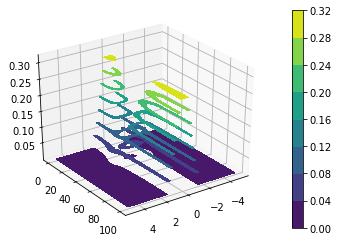

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(30,55)
cf = ax.contourf(xx,yy,WrowsIII)
fig.colorbar(cf)


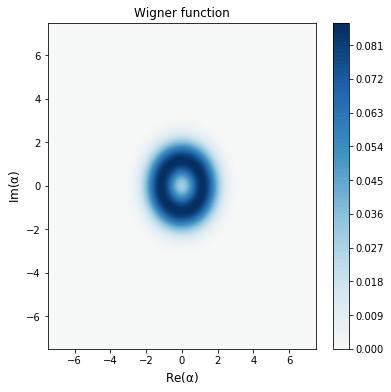

In [63]:
# ckey = plt.contourf(WsII[10])
# plt.colorbar(ckey)
#fig, ax = plt.subplots()
#wmap = wigner_cmap(WsIII[130])
cf = plot_wigner(statesIII[112].ptrace(6), colorbar = True)
#fig.colorbar(cf)

In [62]:
statesIII[112].ptrace(6)

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[4.05378071e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.40975976e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.39758432e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.34287908e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.30355847e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.80483924e-05 0.00000000e+00 0.00000000e+

In [166]:
input_vec = np.linspace(-5,5,100)
statesIII = resultIII.states
Wbig = []; Wall = []; vectemp = []; vecbig = []
starttimer()
for i, tstate in enumerate(statesIII):
    ProgressBar(i, statesIII)
    W, yvec = wigner(tstate.ptrace(6), input_vec,input_vec, method = 'fft')
    Wall.append(W)
for nrow in range(len(input_vec)):
    temp = np.hstack([W[nrow] for W in Wall])
    Wbig.append(temp)
tvec = np.hstack([[t[i],]*len(input_vec) for i in range(len(t))])
endtimer() 

10.0% done   
20.0% done   
30.0% done   
40.0% done   
50.0% done   
60.0% done   
70.0% done   
80.0% done   
90.0% done   
Runtime : 5.98872 secs


TypeError: plot_surface() missing 2 required positional arguments: 'Y' and 'Z'

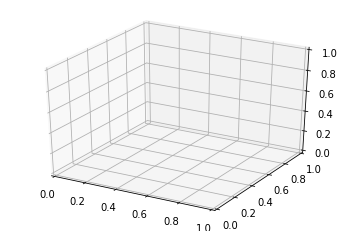

In [183]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
xx,yy = np.meshgrid([t,]*len(input_vec)input_vec)
np.asarray(Wbig).shape
xx.shape
#ax.plot_surface(xx,yy,np.asarray(Wbig), cstride = 100)

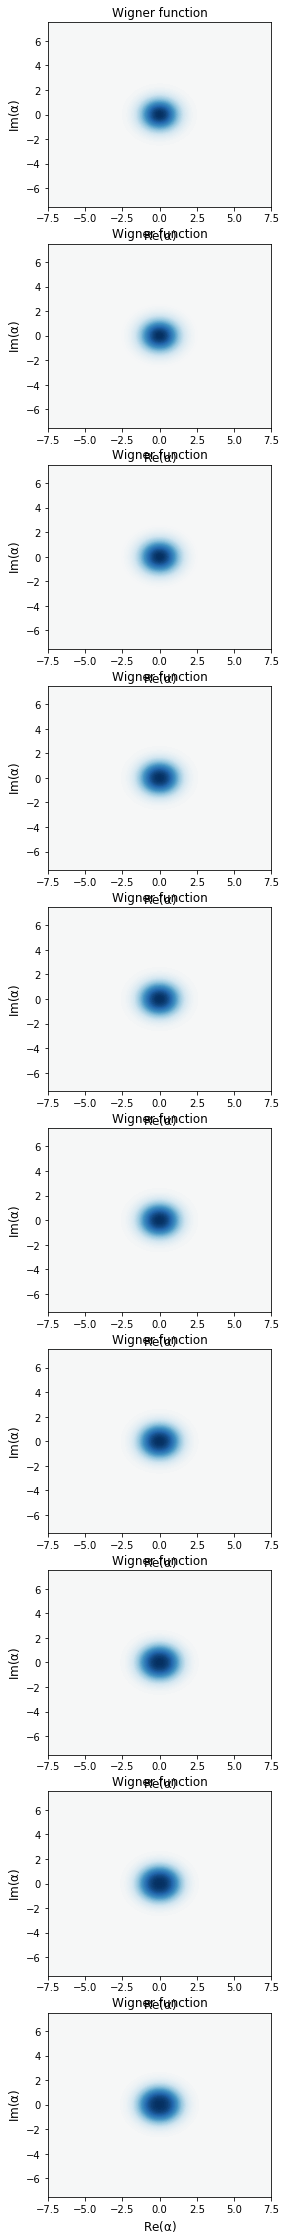

In [25]:
j = 10
start = 70
fig, ax = plt.subplots(j, figsize = (4,4*j))
for i in range(j):
    ind = i+start
    wmap = wigner_cmap(WsIII[ind])
    plot_wigner(statesIII[ind].ptrace(6), ax = ax[i])

In [23]:
print("ello")

ello
